# Human and Virus DNA Classification with TensorFlow 2

In this notebook, we will classify human and viral DNA with Deep Learning using TensorFlow 2. At the end of this tutorial, our model will reach approximately 90% accuracy. But first, we need to talk about the research and some terminology.

## ViraMiner: Deep learning on raw DNA sequences for identifying viral genomes in human samples

We will follow ViraMiner [paper](https://doi.org/10.1371/journal.pone.0222271) and [code](https://github.com/NeuroCSUT/ViraMiner) which is published by **Vicente R. et.al.** You can access the original article and source code. I have made some updates to the original code for educational purposes.

- Updated code base from Python 2 to Python 3.
- Added modules like pandas and removed plain Python code for I/O.
- Used single model.

The human virome is the collection of all viruses that reside in and on the human body. Correlative evidence suggesting that viruses may be involved in the development of autoimmune diseases such as diabetes and multiple sclerosis. 

**Next Generation Sequencing (NGS)** technologies provide a powerful tool to obtain directly the DNA sequences present in clinical samples without any prior knowledge of the biospecimens. The term metagenomics implies complete sequencing and recovering of all non-human genetic material that might be present in a human sample.

**BLAST and HMMER3** are commonly used algorithms for viral discovery in metagenomic samples. Machine Learning is also a different approach. A different approaches consist of using machine learning techniques to learn from examples to classify viral genomes. **(Vicente R. et.al.)**

We will use Convolutional Neural Networks (CNN) on raw metagenomic contigs to identify potential viral sequences across different human samples in this notebook.

## Dataset
We will use [ViraMiner](https://github.com/NeuroCSUT/ViraMiner) dataset and model in this notebook.

### How this DNA data collected and cleaned?
DNA data collected from 19 different experiments and sequenced from different human sample types (serum, skin, condylomata). These contigs were combined, shuffled, and partitioned into training (80%), validation (10%), and testing (10%) sets. 

The metagenomic sequences in this dataset were generated using Next Generation Sequencing platforms such as the NextSeq, Miseq, and HiSeq. Derived from human samples belonging to different patient groups.

All the sequencing experiments were processed and analyzed using a benchmarked bioinformatics workflow. Analysis with quality checking where reads are filtered based on their Phred quality score. Quality checked reads that align to human, bacterial, phage and vector DNA with >95% identity. Over 75% of their length are subtracted from further analysis using BWA-MEM. The reads that are left are normalized and then assembled using the IDBA-UD, Trinity, SOAPdenovo, and SOAPdenovo- Trans assemblers. The assembled contigs are then subjected to taxonomic classification using BLAST. 

This dataset included 19 different NGS experiments that were analyzed and labeled by PCJ-BLAST. Labeled sequences were divided into equal pieces (300bp), each one of them was labeled as the original sequence and remaining nucleotides at the end of the contigs were removed. All contigs that contained even one “N” letter (reference to any nucleotide) were removed. **(Vicente R. et.al.)**

### Download Dataset
I simplified the ViraMiner dataset for this notebook. You can download simplified dataset from **dataset** folder.

Dataset folder contains 3 csv files: **train.csv, validation.csv and test.csv**.

We define the full path of our dataset.

In [24]:
dataset_path = '/home/aaslan/Code/ML/viral-dna-classification/dataset/'

We use **pandas** package to reading csv files and processing DataFrames. Pandas supplies many functions to sorting, filtering and clearing the dataset. To further information, you can look at documentation of pandas from [here](https://pandas.pydata.org/). 

We import **numpy** package also. *NumPy is the fundamental package for scientific computing with Python.* It provides working with N-dimensional arrays easily and fast. We will use numpy package in upcoming lines.

We import pandas firstly. Then we read csv files by **read_csv** function and assign it to the **train_set** variable with pandas. We read other sets also.

In [25]:
import pandas as pd
import numpy as np

train_set = pd.read_csv(dataset_path + "train.csv")
validation_set = pd.read_csv(dataset_path + "validation.csv")
test_set = pd.read_csv(dataset_path + "test.csv")

Let's see how our training set looks like with **head()** attribute.

First column is **DNA sequences** with 300bp length, second column is a **label** of this sequence. If DNA sequence is belongs to human it is labelled as **0** and also vice versa.

In [26]:
train_set.head()

,1,2
0,CAAGCCAAGATTTTCTCGCGTCACACTACTCATGACCATTGTATTA...,0
1,AACGAAGCACGGGCCGAGAGATTGAGGAACCAAGGTCCAGCTCTAG...,0
2,TAGTGGGTGAGGTTTCTATTTCCATAATGATCTCGCCTCAATTACT...,0
3,ATATGACCATTCTTGCAAGGTAACACAGGTACATTTTCACAAAGTG...,0
4,GGTCTTAAAACAACAGAAATTTTTTCCATCACAGTTGCAGAAATTA...,0


**info()** attribute summarizes our training set. You can show that there are **211239** lines in dataset.

In [27]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211239 entries, 0 to 211238
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   1       211239 non-null  object
 1   2       211239 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


## Model Configurations & Helper Functions

These are some of the hyperparameters and configurations of our model. We will use them in our model. To configure and tune our model easily, we define them here.

In [28]:
batch_size = 4 #128
learning_rate = 0.0001
epochs = 10
dropout = 0.1
lr_decay = True
train_steps_per_epoch = train_set.shape[0] // batch_size

Here is our learning decay calculation and updating function. 

In [29]:
def lr_decay_per_epoch(epoch):
    initial_lrate = learning_rate
    drop = 0.5
    epochs_drop = 5.0
    lrate = initial_lrate * np.power(drop,int((1+epoch)/epochs_drop))
    lrate = np.max([initial_lrate/100,lrate])
    return lrate

This is our helper function to convert DNA sequence to one hot encoding. Takes dataset as an input and return one encoded sequences and labels.

In [30]:
def DNA_to_onehot(dataset):
    options_onehot = {'A': [1,0,0,0,0],'C' :[0,1,0,0,0], 'G':[0,0,1,0,0] ,'T':[0,0,0,1,0],'N':[0,0,0,0,1]}
    sequences = []
    labels = []
    for index, row in dataset.iterrows():
        sequences.append(list(map(lambda e: options_onehot[e], row[0])))
        labels.append(row[1])
    sequences = sequences
    return np.array(sequences), np.array(labels)

This function will generate our training batches according to our configurations which we defined above. This generator will feed our neural network step by step because our training set is too big to store whole dataset in the memory.

In [31]:
def generate_batches(dataset, batch_size):
    train_steps_per_epoch = dataset.shape[0] // batch_size

    while 1:
        for i in range(0, train_steps_per_epoch):

            seqs, labels = DNA_to_onehot(dataset.iloc[i*batch_size:(i+1)*batch_size,:])

            yield seqs, labels

Validation set is smaller than training set. So, we can store whole validation set in one time. We can use generators in validation set like training set, but we don't need that.

We store validation sequences and labels in different variables: **val_seqs** and **val_labels**. We use DNA_to_onehot function which we defined above.

In [32]:
val_seqs, val_labels = DNA_to_onehot(validation_set)

## Model

Importing necessary modules from Keras.

In [33]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, concatenate, Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam, SGD

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

### Model Structure

This is the most important part. In this lines we create our model's layers, activations and optimizers. We are using ViraMiner model as a base model also. Let's visualize how our model looks like.

![ViraMiner Model Structure](https://pymed.ai/images/uploads/viraminer-model.png)

This model contains **two convolutional branches** that contribute different types of information to the final fully-connected decision-making layer. 
A convolutional layer followed by average operator provides important information about the frequency of patterns. In such a case, while losing information about the maximal activation (best match), we gain information about frequency—the average cannot be high if only a few good matches were found.
We combine feature maps processed by averaging and by max operators. This allows the model to base its decisions on both pattern-matching and pattern-frequency information. **(Vicente R. et.al.)**

In original ViraMiner article, authors trained frequency and pattern branches separately. But here we train them once because of educational purposes. 

Input layer shape is 300x5. 300 is length of sequence and 5 is one hot encoded form of **ACTGN** nucleotides.

In [34]:
inputs = Input(shape=(300,5))

This is a frequency layer.

In [35]:
first_freq = Conv1D(1000,8, activation="relu")(inputs)
freq_pooling = GlobalAveragePooling1D()(first_freq)
drop_freq = Dropout(dropout)(freq_pooling)
fc_layer1 = Dense(1000, activation="relu", name="fc_layer1")(drop_freq)

This is a pattern layer.

In [36]:
first_pattern = Conv1D(1200,11, activation="relu")(inputs)
pattern_pooling = GlobalMaxPooling1D()(first_pattern)
drop_pattern = Dropout(dropout)(pattern_pooling)
fc_layer2 = Dense(1200, activation="relu", name="fc_layer2")(drop_pattern)

Concatenation of frequency and pattern layers.

In [37]:
concatenation = concatenate([fc_layer1, fc_layer2])

Dropout applied to concatenation layer.

In [38]:
drop_fc = Dropout(dropout, name="drop_fc1")(concatenation)

Final dense layer.

In [39]:
final = Dense(1, activation="sigmoid")(drop_fc)

We define our model variable input to output and compile it. We use adam optimizer and binary crossentropy as a loss function. After that, we summarize model structure.

In [40]:
model = Model(inputs, final)
model.compile(optimizer = Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 5)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 293, 1000)    41000       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 290, 1200)    67200       input_1[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1000)         0           conv1d[0][0]                     
______________________________________________________________________________________________

## Training

We will save only best model with **ModelCheckpoint** callback. It will save model only which has minimum validation loss value. Also **EarlyStopping** will be activated if validation loss does not decrease 5 times in a row. Lastly, we appended **LearningRateScheduler** to decrease learning rate after some epochs.

In [41]:
callbacks=[]
callbacks.append(ModelCheckpoint(filepath="best.h5", verbose=1, save_best_only=True, monitor='val_loss'))
callbacks.append(EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5))

if lr_decay == True:
    callbacks.append(LearningRateScheduler(lr_decay_per_epoch))

It is time to fit our model!

In [42]:
model.fit(generate_batches(train_set, batch_size),
        steps_per_epoch = train_steps_per_epoch, 
        epochs = epochs, workers = 1, 
        use_multiprocessing = True, verbose = 1,  callbacks = callbacks,
        validation_data=(np.array(val_seqs), val_labels))

Epoch 1/10
52804/52809 [============================>.] - ETA: 0s - loss: 0.0941 - accuracy: 0.9788
Epoch 00001: val_loss improved from inf to 0.08238, saving model to best.h5
52809/52809 [==============================] - 150s 3ms/step - loss: 0.0941 - accuracy: 0.9788 - val_loss: 0.0824 - val_accuracy: 0.9798 - lr: 1.0000e-04
Epoch 2/10
52804/52809 [============================>.] - ETA: 0s - loss: 0.0833 - accuracy: 0.9789
Epoch 00002: val_loss improved from 0.08238 to 0.07816, saving model to best.h5
52809/52809 [==============================] - 148s 3ms/step - loss: 0.0833 - accuracy: 0.9789 - val_loss: 0.0782 - val_accuracy: 0.9798 - lr: 1.0000e-04
Epoch 3/10
52790/52809 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9790
Epoch 00003: val_loss improved from 0.07816 to 0.07646, saving model to best.h5
52809/52809 [==============================] - 145s 3ms/step - loss: 0.0787 - accuracy: 0.9790 - val_loss: 0.0765 - val_accuracy: 0.9800 - lr: 1.0000e-04
Ep

## Evaluation

Importing evaluation and ploting modules.

In [44]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

We convert test sequences to one hot encodings as we did before.

In [45]:
test_seqs, test_labels = DNA_to_onehot(test_set)
test_steps_per_epoch = test_set.shape[0] // batch_size

Load best model from file which we saved before.

In [46]:
model = load_model("best.h5")

Prediction of test set with our model. Last line calculates auroc score. 

In [47]:
pred_probas = model.predict_generator(generate_batches(test_set, batch_size), 
                                      steps=test_steps_per_epoch + 1)
pred_probas = pred_probas[:len(test_labels),:]
roc_auc_score(test_labels, pred_probas)

Instructions for updating:
Please use Model.predict, which supports generators.


0.8925676038994342

Calculating false-postive and true-positive values for ROC curve.

In [48]:
fpr, tpr, thresholds = roc_curve(test_labels, pred_probas)

Ploting the ROC curve.

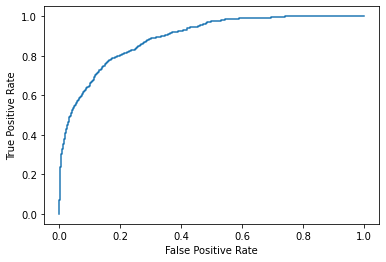

In [49]:
def plot_roc_curve(fpr,tpr): 
    plt.plot(fpr, tpr) 
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.show()
    
plot_roc_curve(fpr, tpr)

With this tutorial's default configurations, we get loss: 0.0520, acccuracy: 0.9847, validation loss: 0.0701, validation accuracy: 0.9826. Our ROC AUC score is approximately 0.897. It is little bit less than original article which is 0.923.

These values can be changed train by train, but does not deviate much.

## Conclusion

We classified DNA data in this tutorial. We used ViraMiner dataset and base model to achieve this. Our dataset consists of 300bp in length sequences. These sequences gathered from different sources. In final evaluation, our model achieved 0.897 on ROC AUC score. 

If you want to get better results on this model you can read original ViraMiner [paper](https://doi.org/10.1371/journal.pone.0222271). Different approaches and hyperparameter available in this paper.